In [1]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, roc_auc_score


RANDOM_STATE = 42


In [6]:
import pandas as pd

train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

train.head(), train.shape


(                 id                                       comment_text  toxic  \
 0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
 1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
 2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
 3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
 4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   
 
    severe_toxic  obscene  threat  insult  identity_hate  
 0             0        0       0       0              0  
 1             0        0       0       0              0  
 2             0        0       0       0              0  
 3             0        0       0       0              0  
 4             0        0       0       0              0  ,
 (159571, 8))

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score

RANDOM_STATE = 42

label_cols = ['toxic', 'severe_toxic', 'obscene',
              'threat', 'insult', 'identity_hate']


Counts:
 toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64

Proportions:
 toxic            0.095844
obscene          0.052948
insult           0.049364
severe_toxic     0.009996
identity_hate    0.008805
threat           0.002996
dtype: float64


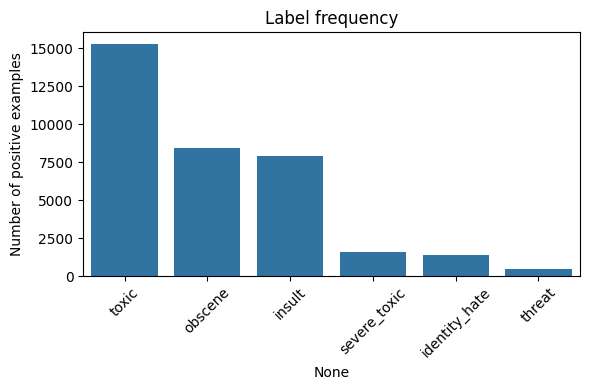

In [8]:
# The number and proportion of positive samples for each label
label_counts = train[label_cols].sum().sort_values(ascending=False)
label_props = (label_counts / len(train)).sort_values(ascending=False)

print("Counts:\n", label_counts)
print("\nProportions:\n", label_props)

plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks(rotation=45)
plt.ylabel("Number of positive examples")
plt.title("Label frequency")
plt.tight_layout()
plt.show()


In [9]:
train['any_toxic'] = (train[label_cols].sum(axis=1) > 0).astype(int)
train['any_toxic'].value_counts(), train['any_toxic'].mean()


(any_toxic
 0    143346
 1     16225
 Name: count, dtype: int64,
 np.float64(0.10167887648758234))

count    159571.000000
mean         67.273527
std          99.230702
min           1.000000
25%          17.000000
50%          36.000000
75%          75.000000
max        1411.000000
Name: word_len, dtype: float64


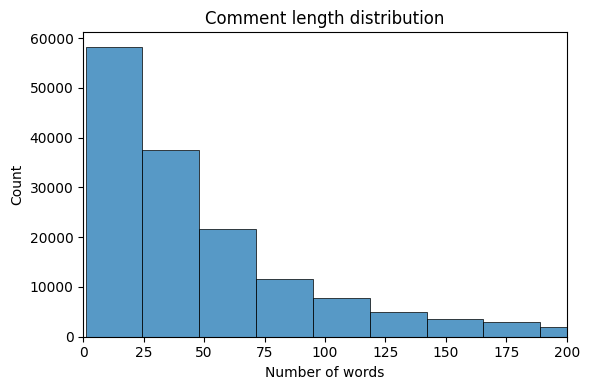

In [10]:
train['char_len'] = train['comment_text'].str.len()
train['word_len'] = train['comment_text'].str.split().apply(len)

print(train['word_len'].describe())

plt.figure(figsize=(6,4))
sns.histplot(train['word_len'], bins=60)
plt.xlabel("Number of words")
plt.ylabel("Count")
plt.title("Comment length distribution")
plt.xlim(0, 200)  # Pos count & ratio per label
plt.tight_layout()
plt.show()


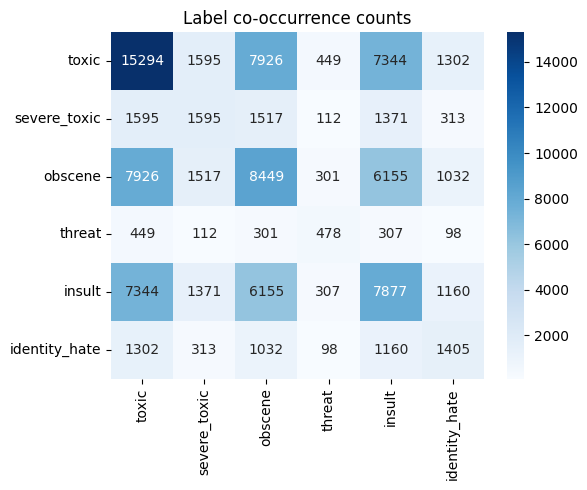

In [11]:
cooc = train[label_cols].T.dot(train[label_cols])  # 6x6 matrix

plt.figure(figsize=(6,5))
sns.heatmap(cooc, annot=True, fmt="d", cmap="Blues")
plt.title("Label co-occurrence counts")
plt.tight_layout()
plt.show()


In [12]:
X_text = train['comment_text']
y = train[label_cols].values

X_train, X_val, y_train, y_val = train_test_split(
    X_text, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=train['any_toxic']
)

len(X_train), len(X_val)


(127656, 31915)

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=100000,
    ngram_range=(1, 2),    # unigrams + bigrams
    stop_words='english',
    min_df=3
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)

X_train_tfidf.shape, X_val_tfidf.shape


((127656, 100000), (31915, 100000))

In [14]:
base_clf = OneVsRestClassifier(
    LogisticRegression(
        solver='liblinear',
        C=1.0,
        class_weight='balanced',  # Handling class imbalance
        max_iter=1000
    )
)

base_clf.fit(X_train_tfidf, y_train)

y_val_proba = base_clf.predict_proba(X_val_tfidf)
y_val_pred  = (y_val_proba >= 0.5).astype(int)


In [15]:
print(classification_report(y_val, y_val_pred, target_names=label_cols))

# per-label ROC-AUC
per_label_auc = []
for i, label in enumerate(label_cols):
    auc = roc_auc_score(y_val[:, i], y_val_proba[:, i])
    per_label_auc.append(auc)
    print(f"{label}: ROC-AUC = {auc:.4f}")

print("Mean column-wise ROC-AUC:", np.mean(per_label_auc))


               precision    recall  f1-score   support

        toxic       0.66      0.84      0.74      3046
 severe_toxic       0.27      0.83      0.40       305
      obscene       0.69      0.87      0.77      1662
       threat       0.24      0.65      0.36        98
       insult       0.57      0.86      0.69      1576
identity_hate       0.22      0.73      0.34       259

    micro avg       0.56      0.84      0.68      6946
    macro avg       0.44      0.80      0.55      6946
 weighted avg       0.61      0.84      0.70      6946
  samples avg       0.06      0.08      0.07      6946

toxic: ROC-AUC = 0.9710
severe_toxic: ROC-AUC = 0.9820
obscene: ROC-AUC = 0.9854
threat: ROC-AUC = 0.9785
insult: ROC-AUC = 0.9782
identity_hate: ROC-AUC = 0.9709
Mean column-wise ROC-AUC: 0.9776780130374192


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
Cs = [0.1, 0.5, 1.0, 3.0, 10.0]
results = []

for C in Cs:
    clf = OneVsRestClassifier(
        LogisticRegression(
            solver='liblinear',
            C=C,
            class_weight='balanced',
            max_iter=1000
        )
    )
    clf.fit(X_train_tfidf, y_train)
    y_proba = clf.predict_proba(X_val_tfidf)
    per_label_auc = [
        roc_auc_score(y_val[:, i], y_proba[:, i])
        for i in range(len(label_cols))
    ]
    macro_auc = np.mean(per_label_auc)

    y_pred = (y_proba >= 0.5).astype(int)
    macro_f1 = f1_score(y_val, y_pred, average='macro')

    results.append((C, macro_auc, macro_f1))
    print(f"C={C}: mean AUC={macro_auc:.4f}, macro F1={macro_f1:.4f}")


C=0.1: mean AUC=0.9753, macro F1=0.5002
C=0.5: mean AUC=0.9776, macro F1=0.5324
C=1.0: mean AUC=0.9777, macro F1=0.5500
C=3.0: mean AUC=0.9763, macro F1=0.5741
C=10.0: mean AUC=0.9722, macro F1=0.5878


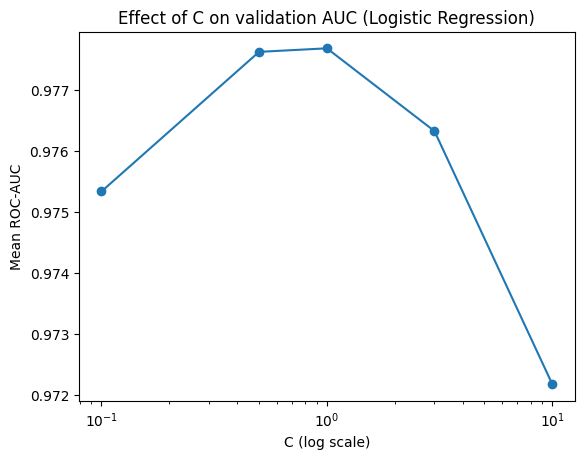

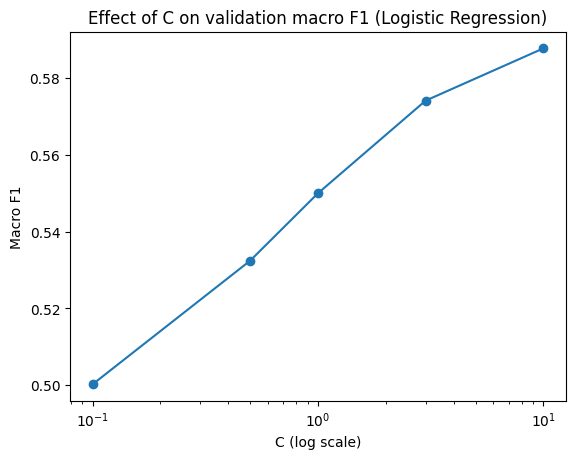

In [17]:
Cs_list      = [r[0] for r in results]
auc_list     = [r[1] for r in results]
macro_f1_list = [r[2] for r in results]

plt.figure()
plt.plot(Cs_list, auc_list, marker='o')
plt.xscale('log')
plt.xlabel("C (log scale)")
plt.ylabel("Mean ROC-AUC")
plt.title("Effect of C on validation AUC (Logistic Regression)")
plt.show()

plt.figure()
plt.plot(Cs_list, macro_f1_list, marker='o')
plt.xscale('log')
plt.xlabel("C (log scale)")
plt.ylabel("Macro F1")
plt.title("Effect of C on validation macro F1 (Logistic Regression)")
plt.show()


In [18]:
svm_clf = OneVsRestClassifier(
    LinearSVC(
        C=0.5,
        class_weight='balanced'
    )
)

svm_clf.fit(X_train_tfidf, y_train)

y_val_decision = svm_clf.decision_function(X_val_tfidf)
y_val_pred_svm = (y_val_decision > 0).astype(int)

print(classification_report(y_val, y_val_pred_svm, target_names=label_cols))

macro_f1_svm = f1_score(y_val, y_val_pred_svm, average='macro')
print("SVM macro F1:", macro_f1_svm)


               precision    recall  f1-score   support

        toxic       0.70      0.81      0.75      3046
 severe_toxic       0.30      0.68      0.42       305
      obscene       0.73      0.84      0.78      1662
       threat       0.42      0.54      0.47        98
       insult       0.60      0.80      0.69      1576
identity_hate       0.30      0.58      0.40       259

    micro avg       0.63      0.80      0.70      6946
    macro avg       0.51      0.71      0.59      6946
 weighted avg       0.65      0.80      0.71      6946
  samples avg       0.06      0.07      0.07      6946

SVM macro F1: 0.5852112327783052


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
from sklearn.decomposition import TruncatedSVD

# Perform LSA dimensionality reduction using TF-IDF.
svd = TruncatedSVD(
    n_components=100,
    random_state=RANDOM_STATE
)

X_train_svd = svd.fit_transform(X_train_tfidf)
X_val_svd   = svd.transform(X_val_tfidf)

X_train_svd.shape, X_val_svd.shape


((127656, 100), (31915, 100))

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score
import numpy as np

rf_clf = OneVsRestClassifier(
    RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
)

rf_clf.fit(X_train_svd, y_train)

# 概率预测（每个 label 一列）
y_val_proba_rf = rf_clf.predict_proba(X_val_svd)
y_val_pred_rf  = (y_val_proba_rf >= 0.5).astype(int)

print(classification_report(y_val, y_val_pred_rf, target_names=label_cols))

# per-label ROC-AUC
per_label_auc_rf = []
for i, label in enumerate(label_cols):
    auc = roc_auc_score(y_val[:, i], y_val_proba_rf[:, i])
    per_label_auc_rf.append(auc)
    print(f"{label}: RF ROC-AUC = {auc:.4f}")

print("RF Mean column-wise ROC-AUC:", np.mean(per_label_auc_rf))

macro_f1_rf = f1_score(y_val, y_val_pred_rf, average='macro')
print("RF Macro F1:", macro_f1_rf)


               precision    recall  f1-score   support

        toxic       0.91      0.44      0.60      3046
 severe_toxic       0.53      0.18      0.27       305
      obscene       0.91      0.58      0.71      1662
       threat       0.83      0.05      0.10        98
       insult       0.80      0.46      0.59      1576
identity_hate       0.60      0.10      0.17       259

    micro avg       0.87      0.45      0.59      6946
    macro avg       0.76      0.30      0.40      6946
 weighted avg       0.86      0.45      0.58      6946
  samples avg       0.04      0.04      0.04      6946

toxic: RF ROC-AUC = 0.9058
severe_toxic: RF ROC-AUC = 0.9658
obscene: RF ROC-AUC = 0.9423
threat: RF ROC-AUC = 0.8213
insult: RF ROC-AUC = 0.9259
identity_hate: RF ROC-AUC = 0.8782
RF Mean column-wise ROC-AUC: 0.9065251548981509
RF Macro F1: 0.40386444504464286


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
